## Write an Algorithm for a Dog Identification App 

### Based on Convolutional Neural Networks

Let's stand the problem :
This project accepts any user-supplied image as input. If a dog is detected in the image, it will provide an estimate of the dog's breed. If a human is detected, it will provide an estimate of the dog breed that is most resembling. 

In practice we should piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed. However, it is just for learning purposes. Then, we will go ahead.

## Import Datasets

First of all, lets load our datasets

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).

lfw/Kate_Lee/Kate_Lee_0001.jpg


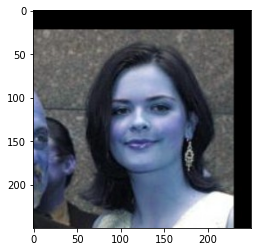

Number of faces detected: 1


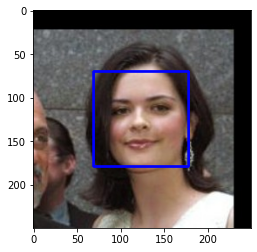

In [2]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
print(human_files[0])
img = cv2.imread(human_files[0])
plt.imshow(img)
plt.show()
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

### Write a Human Face Detector

Once seen that. We will build a function that returns True if a human face is detected in an image and `False` otherwise.
Our function will take as input a file path and will return a boolean value.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

Now, lets test our function with a part of our dataset. An see its performance agains human and dog images.

In [4]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_faces_detected  = 0
false_human_faces_detected  = 0
for file in human_files_short:
    if face_detector(file):
        human_faces_detected += 1 
classified_human_faces = 100 * human_faces_detected/len(human_files_short)
print("% Correctly classified human faces: ", classified_human_faces)

for file in dog_files_short:
    if face_detector(file):
        false_human_faces_detected += 1 
classified_dog_faces_as_humans = 100 * false_human_faces_detected/len(dog_files_short)
print("% Wrong dog faces classied as human : ", classified_dog_faces_as_humans)

% Correctly classified human faces:  99.0
% Wrong dog faces classied as human :  7.0


This is the most clear and easy to use method. However, there exists more complex solutions like the proposed in:
https://github.com/timesler/facenet-pytorch/

In [11]:
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]


human_faces_detected  = 0
false_human_faces_detected  = 0
for file in human_files_short:
    img = cv2.imread(file)
    dim = (160, 160)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    x_aligned = mtcnn(resized, return_prob=False)
    if x_aligned is not None:
        human_faces_detected += 1 
classified_human_faces = 100 * human_faces_detected/len(human_files_short)
print("% Correctly classified human faces: ", classified_human_faces)

for file in dog_files_short:
    img = cv2.imread(file)
    dim = (160, 160)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    x_aligned = mtcnn(resized, return_prob=False)
    if x_aligned is not None:
        false_human_faces_detected += 1 
classified_dog_faces_as_humans = 100 * false_human_faces_detected/len(dog_files_short)
print("% Wrong dog faces classied as human : ", classified_dog_faces_as_humans)


% Correctly classified human faces:  98.0
% Wrong dog faces classied as human :  7.0


It is a complex solution, although its parameters are more difficult to tune. Because of that, we will proceed with the first option, the cascade classifier.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

We will use a pretrained VGG-16 model with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks. 

In [5]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()
VGG16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Implement the Dog Detector

First, we will build a helper function that given a image path predicts the class of the image content in Vgg16 net. Then, we will build our dog_detector.

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), we can see that Vgg16 has been trained with a lot of dog breeds. More explicetly, the dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`. Then, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Our `dog_detector` function below will returns `True` if a dog is detected in an image (and `False` if not).

In [6]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    
    n_channels = 3
    shape = 224
    
    img_transform = transforms.Compose([
            transforms.Resize((shape, shape)),
            transforms.ToTensor(),
            normalize,
    ])

    
    img_data = Image.open(img_path)
    image_normarlized = img_transform(img_data).view(-1,n_channels,shape,shape).cuda()
    
    VGG16.eval()
    output = VGG16.forward(image_normarlized)
    _, pred = torch.max(output, 1)  
    
    pred = pred.cpu().numpy()
    
    return pred # predicted class index



In [7]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    vgg_class = VGG16_predict(img_path)
    if 151 <=  vgg_class <= 268 :
        dog_class = True
    else:
        dog_class = False
    
    return dog_class # true/false
dog_detector('dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg')

True

Let's test the dog detector

In [9]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
dog_faces_detected  = 0
false_dog_faces_detected  = 0

for file in dog_files_short:
    if dog_detector(file):
        dog_faces_detected += 1 
classified_dog_faces = 100 * dog_faces_detected/len(dog_files_short)
print("% Correctly classified dog faces: ", classified_dog_faces)

for file in human_files_short:
    if dog_detector(file):
        false_dog_faces_detected += 1 
classified_human_faces_as_dogs = 100 * false_dog_faces_detected/len(human_files_short)
print("% Wrong human faces classied as dogs : ", classified_human_faces_as_dogs)

% Correctly classified dog faces:  99.0
% Wrong human faces classied as dogs :  0.0


## Create a CNN to Classify Dog Breeds (from Scratch)

Now let's start bulding the dog breed classifier. We will do a first approach from scratch, without transfer learning. 

The task of assigning breed to dogs from images is considered exceptionally challenging. To see why, consider that even a human would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


It is worth mentioning that random chance is really low: Not to mention that the classes may be a bit imbalance, but a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%. 



Now, lets define some image transformations for data augmentation and the Dataloaders to load the dataset

In [10]:
import torch

# check if CUDA is available
use_cuda = torch.cuda.is_available()
print("using_cuda: ", use_cuda)
import os
from torchvision import datasets
from torchvision import transforms
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

img_size = 224

normalize = transforms.Normalize(mean=[0.5,0.5,0.5],
                                 std=[0.5,0.5,0.5])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    normalize
])

train_data = datasets.ImageFolder("dogImages/train/", transform=train_transform)
valid_data = datasets.ImageFolder("dogImages/valid/", transform=valid_transform)
test_data = datasets.ImageFolder("dogImages/test/", transform=test_transform)

print(len(train_data))
loaders_scratch = {}
loaders_scratch["train"] = torch.utils.data.DataLoader(train_data, batch_size=24, shuffle=True)
loaders_scratch["valid"] = torch.utils.data.DataLoader(valid_data, batch_size=24, shuffle=True)
loaders_scratch["test"] = torch.utils.data.DataLoader(test_data, batch_size=24, shuffle=True)


using_cuda:  True
6680


The transform resizes the image by random, cropping. The randomness will give us extra data set images to train our model. 
We will resize the image such as the input for de model becomes a 224 quadratic array. We do so because the Vgg model (and most of the pre-trained models) is trained in the ImageNet dataset with images of size 224x224.

The used dataset contains only 6680 images. Therefore, it is a must to use data augmentation. I have used 3 different techniques:
Random crop.
Random Horizontal Flip.
Random Rotation.


Let's see some examples of the resulting images


tensor([ 61,  90, 101, 104, 129,  57,  11,  78,  67,  56,  34,  90,  87,  71,
        104, 116,  99,  82,   2,  96,  55, 104,  86,  95])


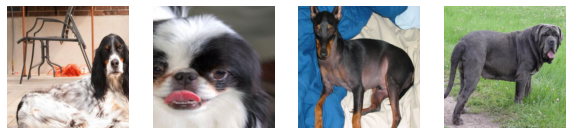

In [11]:
## Lets se some examples of the training loader
import matplotlib.pyplot as plt                        
%matplotlib inline    

data_iter = iter(loaders_scratch["train"])


def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

images, labels = next(data_iter)
print(labels)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)

### Model Architecture

Now, I define the CNN to classify dog breed.

In [12]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        
        self.max_pool = nn.MaxPool2d(2,2)
        
        self.dropout = nn.Dropout(0.3)
    
        self.fc1 = nn.Linear(28*28*128, 512)
        self.fc2 = nn.Linear(512, 133)
        
        #self.logmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        x = self.dropout(x)
        x = F.relu(self.conv3(x))
        x = self.max_pool(x)
        x = x.view(-1, 28*28*128)
        x = self.dropout(x)
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x)
        
        return x

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

It is built a model with 3 Convolution followed by three max pooling layers. I tried to get a low number of features and I have increased them empirically.

We used 2 dropouts to fight against overfitting. Finally, it is used 3 fully connected layers to reduce the number of features lear more general parameters and get the 113 resulting classes.

The given architecture is far for being the optimal one. However, we have really few data and if we increase it much more we will get overfitting.

###  Loss Function and Optimizer

Now, it is define the optimizer and the loss fucntion. They are pretty much the standard for cnn classification problems.

In [13]:
import torch.optim as optim

criterion_scratch = nn.CrossEntropyLoss()

optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)

### Train and Validate the Model

Now we are going to train our model build from scratch

In [18]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 

    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        running_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            optimizer.zero_grad()
            
            output_log = model(data)
                        
            loss = criterion(output_log, target)
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            
        train_loss = running_loss/len(loaders['train'])
        
        ## Alternatively, the loss can be computed as:
        ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            output_log = model(data)
            loss = criterion(output_log, target)
            
            valid_loss += loss.item()
            
            
            ## update the average validation loss
        valid_loss = valid_loss/len(loaders["valid"])

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
        ))
        
        ## save the model if validation loss has decreased
        if valid_loss < valid_loss_min:            
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss
            ))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model


# train the model
model_scratch = train(40, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
#model_scratch.load_state_dict(torch.load('model_scratch2.pt'))

Once our model has been trainedm, we can test it. First, we load the model and the we test agains our testing set

In [13]:
import numpy as np

#model_scratch.load_state_dict(torch.load('model_scratch.pt'))
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))



In [ ]:
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

As we can see the performance is really poor. After 40 epoch, we have only achived a 20 % of accuracy. Then, we have study a different approach. Let's try with transfer learning.

## Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images. 

###  Data Loaders for the Dog Dataset for pretrained models

The data augmentation and preprocessing will be really similar to the previous one. However, there are some hyperparameters that must be set as the net was originally trained, like:
- Image size
- Image Normalitzation
...


In [11]:
import torch
# define VGG16 model

# check if CUDA is available
use_cuda = torch.cuda.is_available()
print("using_cuda: ", use_cuda)
import os
from torchvision import datasets
from torchvision import transforms
## Specify appropriate transforms, and batch_sizes

img_size = 224 ##VGG16 train size

#Normalize image pixels
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])


train_data = datasets.ImageFolder("dogImages/train/", transform=train_transform)
valid_data = datasets.ImageFolder("dogImages/valid/", transform=valid_transform)
test_data = datasets.ImageFolder("dogImages/test/", transform=test_transform)

print(len(train_data))
loaders_transfer = {}
loaders_transfer["train"] = torch.utils.data.DataLoader(train_data, batch_size=24, shuffle=True)
loaders_transfer["valid"] = torch.utils.data.DataLoader(valid_data, batch_size=24, shuffle=True)
loaders_transfer["test"] = torch.utils.data.DataLoader(test_data, batch_size=24, shuffle=True)

using_cuda:  True
6680


### Model Architecture of transfer learning model

Use transfer learning to create a CNN to classify dog breed.

In this case we will use a Vgg16 pretrained on the ImageNet dataset. We will froze all the layers, except for the last one. The classificator layer. We will substitute the classifier layer and create a new sequencial for the task. It will be composed by three fc layers and it will be the unique layer that will be trained.
We will add dropout in order to prevent regularization.

In [8]:
import torchvision.models as models
import torch.nn as nn
from collections import OrderedDict

## TODO: Specify model architecture 
model_transfer = models.vgg16(pretrained=True)

for param in model_transfer.features.parameters():
    param.requires_grad = False # froze the feature layers
    

input_features_classifier = model_transfer.classifier[0].in_features
n_dog_classes = 133


classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(input_features_classifier, 4096)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(4096, 1024)),
                          ('relu2', nn.ReLU()),
                          ('drop', nn.Dropout(0.3)),
                          ('fc3', nn.Linear(1024, n_dog_classes))
                          ]))

model_transfer.classifier = classifier
print(model_transfer)
if use_cuda:
    model_transfer = model_transfer.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

We will use the same optimizer and loss function ans before. However, this time we will set only the paramaeters of classifier to the optimizer.

In [10]:
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr=0.001)

In [20]:
# train the model
n_epochs = 40

model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')


Epoch: 1 	Training Loss: 3.143106 	Validation Loss: 1.433549
Validation loss decreased (inf --> 1.433549).  Saving model ...
Epoch: 2 	Training Loss: 1.920715 	Validation Loss: 1.145112
Validation loss decreased (1.433549 --> 1.145112).  Saving model ...
Epoch: 3 	Training Loss: 1.669965 	Validation Loss: 0.980613
Validation loss decreased (1.145112 --> 0.980613).  Saving model ...
Epoch: 4 	Training Loss: 1.549016 	Validation Loss: 1.183568
Epoch: 5 	Training Loss: 1.460319 	Validation Loss: 0.944873
Validation loss decreased (0.980613 --> 0.944873).  Saving model ...
Epoch: 6 	Training Loss: 1.432104 	Validation Loss: 0.925609
Validation loss decreased (0.944873 --> 0.925609).  Saving model ...
Epoch: 7 	Training Loss: 1.426236 	Validation Loss: 0.886108
Validation loss decreased (0.925609 --> 0.886108).  Saving model ...
Epoch: 8 	Training Loss: 1.347986 	Validation Loss: 0.939352
Epoch: 9 	Training Loss: 1.306630 	Validation Loss: 1.003777
Epoch: 10 	Training Loss: 1.298956 	Valida

Once we have our new transfer leaning model trained. Recall, we only trained the classification part of the model. we can reload ir and then evalute it on the testing set,

In [14]:
model_transfer.load_state_dict(torch.load('model_transfer2.pt'))
import numpy as np
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.987141


Test Accuracy: 79% (666/836)


We can see that our new model performs much better than the scratch ones. Nearly 80 %

An it will be all regarding the model creation, training and testing. However, I think that it is interesting to build a function or set up for a server to ask for predictions. A server like flask, for example.

First, we are going to create a function that given a local image path of a dog. We will predict its breed class.

In [13]:
from PIL import ImageFile
from PIL import Image

ImageFile.LOAD_TRUNCATED_IMAGES = True
## Replace "_" for " " for human readability
class_names = [item[4:].replace("_", " ") for item in train_data.classes]
model_transfer.load_state_dict(torch.load('model_transfer2.pt'))

def predict_breed_transfer(img_path):
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    n_channels = 3
    shape = 224
    
    img_transform = transforms.Compose([
            transforms.Resize((shape, shape)),
            transforms.ToTensor(),
            normalize,
    ])

    
    img_data = Image.open(img_path)
    image_normarlized = img_transform(img_data).view(-1,n_channels,shape,shape).cuda()
    
    model_transfer.eval()
    output = model_transfer.forward(image_normarlized)
    _, pred = torch.max(output, 1)  
    
    pred = int(pred.cpu().numpy())
    # load the image and return the predicted breed
    return class_names[pred]

print(predict_breed_transfer("Affenpinscher_00006.jpg"))

Affenpinscher


Finally, We will implement a fun "mock" app. This app will classify our images as dog, human or others. 
if a dog is detected in the image, return the predicted breed.
if a human is detected in the image, return the resembling dog breed.
if neither is detected in the image, provide output that indicates an error.

In [31]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline   

def run_app(img_path):
    if dog_detector(img_path):
        dog_breed = predict_breed_transfer(img_path)
        print("Hello dog!!!, How are you cute?")
        imshow2(img_path)
        print("You are a " + str(dog_breed) + " ,Aren't you?" )
        return ["dog", dog_breed]
    elif face_detector(img_path):
        human_dog_breed = predict_breed_transfer(img_path)
        print("Another human... How boring...")
        imshow2(img_path)
        print("You look like a " + str(human_dog_breed))
        return ["human", human_dog_breed]
    else:
        print("Sorry, I can not see any dog or human in that picture")
        imshow2(img_path)
        return [None, None]
            
import cv2
def imshow2(image):
    img = cv2.imread(image)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.axis('off')
    plt.show()


Let's test our images with some samples. 

three.jpg
Sorry, I can not see any dog or human in that picture


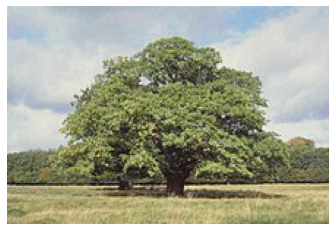

dogs.jpg
Hello dog!!!, How are you cute?


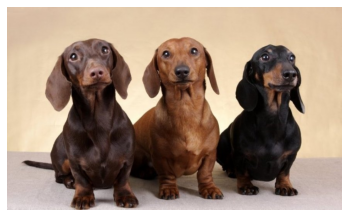

You are a Dachshund ,Aren't you?
human2.jpg
Another human... How boring...


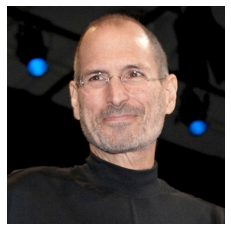

You look like a Pharaoh hound
human3.jpg
Another human... How boring...


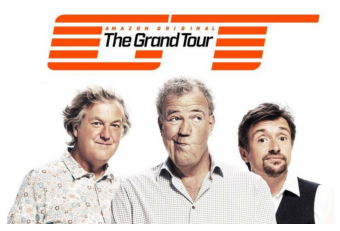

You look like a Pointer
cat.jpg
Another human... How boring...


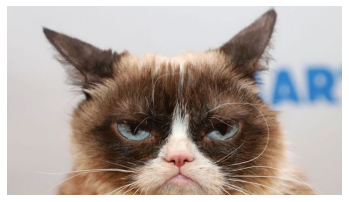

You look like a Pomeranian
bruce.jpg
Hello dog!!!, How are you cute?


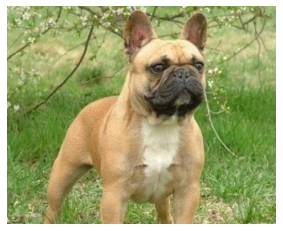

You are a French bulldog ,Aren't you?
human.jpg
Another human... How boring...


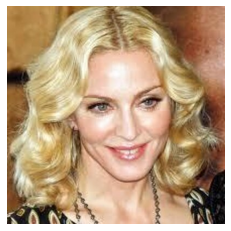

You look like a Dachshund
car.jpeg
Sorry, I can not see any dog or human in that picture


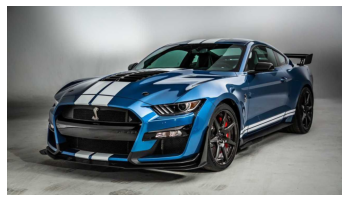

dog2.jpg
Hello dog!!!, How are you cute?


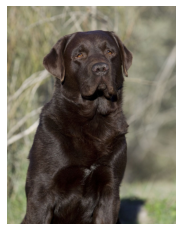

You are a Labrador retriever ,Aren't you?
dog.png
Hello dog!!!, How are you cute?


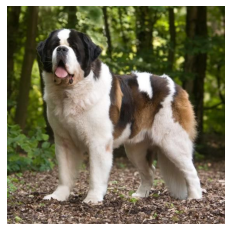

You are a Saint bernard ,Aren't you?
dog3.jpg
Hello dog!!!, How are you cute?


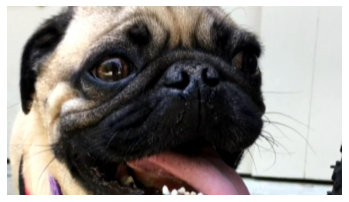

You are a French bulldog ,Aren't you?


In [32]:
img_paths = os.path.join(os.path.realpath("."),"image_final_test")


for file in np.hstack((os.listdir(img_paths))):
    print(file)
    img_full_path = os.path.join(img_paths, file)
    out, breed_class = run_app(img_full_path)

In that example we can see that the function works pretty well! The most surprising result is that the cat is being confused as a human! I would expect to be more closer to a dog than a human...